<a href="https://colab.research.google.com/github/RyanPham19092002/Advancing-Embryo-Selection/blob/main/Advancing_Embryo_Selection(2_Model_VGG_and_ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import cv2
import imutils
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import tensorflow as tf
import shutil

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam, Lion
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D


#create callbacks

In [ ]:
import json
import tensorflow as tf
class SaveBestWeights(tf.keras.callbacks.Callback):
    def __init__(self, filepath_within_20epoch, filepath_architecture,filepath_json_20_epoch, filepath_json, monitor='val_loss', save_best_only=True, patience=0):
        super(SaveBestWeights, self).__init__()
        #self.filepath_weight = filepath_weight
        self.filepath_architecture = filepath_architecture
        self.filepath_within_20epoch = filepath_within_20epoch
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.patience = patience
        self.wait = 0
        self.best_loss = float('inf')
        self.best_accuracy = 0
        self.filepath_json = filepath_json
        self.filepath_json_20_epoch = filepath_json_20_epoch
        self.history = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}  # Lưu giá trị vào dictionary
        self.history_20_epoch = {'accuracy': [], 'loss': [], 'val_accuracy': [], 'val_loss': []}
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        current_accuracy = logs.get('val_accuracy')

        if current_loss is None:
            raise ValueError(f"Model is not compiling with {self.monitor} as a metric.")

        if current_accuracy is None:
            raise ValueError("Validation accuracy is not available.")

        if (current_loss < self.best_loss and current_accuracy == self.best_accuracy) or current_accuracy > self.best_accuracy:
            self.best_loss = current_loss
            self.best_accuracy = current_accuracy
            self.wait = 0
            if self.save_best_only:
                print(f"Save model with val_loss {self.best_loss} and val_accuracy {self.best_accuracy} !")
                #self.model.save_weights(self.filepath_weight, overwrite=True)
                self.model.save(self.filepath_architecture, overwrite=True)
                if epoch <= 20:
                  print(f"Save model within 20 epoch with val_loss {self.best_loss} and val_accuracy {self.best_accuracy} !")
                  self.model.save(self.filepath_within_20epoch, overwrite=True)
        else:
            self.wait += 1
            print(f"Not update Model!")
            if self.wait >= self.patience:
                self.wait = 0
                print(f"End training!")
                self.model.stop_training = True

        # Cập nhật history
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['val_loss'].append(logs.get('val_loss'))

        if epoch <= 20:
                self.history_20_epoch['accuracy'].append(logs.get('accuracy'))
                self.history_20_epoch['loss'].append(logs.get('loss'))
                self.history_20_epoch['val_accuracy'].append(logs.get('val_accuracy'))
                self.history_20_epoch['val_loss'].append(logs.get('val_loss'))
        # Lưu giá trị vào tệp JSON
        with open(self.filepath_json, 'w') as json_file:
            json.dump(self.history, json_file)
        with open(self.filepath_json_20_epoch, 'w') as json_file:
            json.dump(self.history_20_epoch, json_file)

#load data

In [ ]:
from types import NotImplementedType
import tensorflow as tf
from sklearn.model_selection import train_test_split

# # Đường dẫn tới thư mục chứa dữ liệu D3 và D5
# D3_path_train = '/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_D3'
# D5_path_train = '/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_D5'

# D3_path_val = '/content/drive/MyDrive/cuoc_thi_wcs2023_p2/test_data_D3'
# D5_path_val = '/content/drive/MyDrive/cuoc_thi_wcs2023_p2/test_data_D5'

all_data_path_train = '/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_all'
all_data_path_val = '/content/drive/MyDrive/cuoc_thi_wcs2023_p2/val_data_all'
all_data_path_test = '/content/drive/MyDrive/cuoc_thi_wcs2023_p2/test_data_all'

label_mode = 'categorical' #binary , int (spare_categorical)


#tạo data chung
trainData = tf.keras.utils.image_dataset_from_directory(
    all_data_path_train,
    labels='inferred',
    label_mode=label_mode,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    validation_split=None,
    subset=None,
    seed=42
)

valData = tf.keras.utils.image_dataset_from_directory(
    all_data_path_val,
    labels='inferred',
    label_mode=label_mode,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    validation_split=None,
    subset=None,
    seed=42
)

testData = tf.keras.utils.image_dataset_from_directory(
    all_data_path_test,
    labels='inferred',
    label_mode=label_mode,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    validation_split=None,
    subset=None,
    seed=42
)

Found 2150 files belonging to 2 classes.
Found 538 files belonging to 2 classes.
Found 168 files belonging to 2 classes.


In [ ]:
# trainD3 = trainD3.prefetch(tf.data.AUTOTUNE)
# valD3 = valD3.prefetch(tf.data.AUTOTUNE)

# trainD5 = trainD5.prefetch(tf.data.AUTOTUNE)
# valD5 = valD5.prefetch(tf.data.AUTOTUNE)

trainData = trainData.prefetch(tf.data.AUTOTUNE)
valData = valData.prefetch(tf.data.AUTOTUNE)
testData = testData.prefetch(tf.data.AUTOTUNE)

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
if label_mode == 'binary':
    print("label model: ", label_mode)
    # Assuming trainD3 and trainD5 are tf.data.Dataset objects
    # Extract labels from the datasets
    # trainD3_labels = np.concatenate([y.numpy() for _, y in trainD3], axis=0)
    # trainD5_labels = np.concatenate([y.numpy() for _, y in trainD5], axis=0)
    trainData_labels = np.concatenate([y.numpy() for _, y in trainData], axis=0)

    # trainD3_labels_1d = np.squeeze(trainD3_labels)
    # trainD5_labels_1d = np.squeeze(trainD5_labels)
    trainData_labels_1d = np.squeeze(trainData_labels)
    # Calculate class weights for trainD3
    # class_weights_D3 = compute_class_weight('balanced',classes=np.unique(trainD3_labels_1d), y = trainD3_labels_1d)

    # # Calculate class weights for trainD5
    # class_weights_D5 = compute_class_weight('balanced', classes=np.unique(trainD5_labels_1d),y= trainD5_labels_1d)

    # Calculate class weights for trainData
    class_weights_Data = compute_class_weight('balanced', classes=np.unique(trainData_labels_1d),y= trainData_labels_1d)

    # print("Class Weights for trainD3:", class_weights_D3)
    # print("Class Weights for trainD5:", class_weights_D5)
    print("Class Weights for trainData:", class_weights_Data)
elif label_mode == 'categorical':
    print("label model: ", label_mode)
    # trainD3_labels = np.concatenate([y.numpy() for _, y in trainD3], axis=0)
    # trainD5_labels = np.concatenate([y.numpy() for _, y in trainD5], axis=0)
    trainData_labels = np.concatenate([y.numpy() for _, y in trainData], axis=0)

    # trainD3_labels_1d = np.argmax(trainD3_labels, axis=1)
    # trainD5_labels_1d = np.argmax(trainD5_labels, axis=1)
    trainData_labels_1d = np.argmax(trainData_labels, axis=1)

    # # Calculate class weights for trainD3
    # class_weights_D3 = compute_class_weight('balanced',classes=np.unique(trainD3_labels), y = trainD3_labels_1d)

    # # Calculate class weights for trainD5
    # class_weights_D5 = compute_class_weight('balanced', classes=np.unique(trainD5_labels),y= trainD5_labels_1d)

    # Calculate class weights for trainData
    class_weights_Data = compute_class_weight('balanced', classes=np.unique(trainData_labels),y= trainData_labels_1d)

    # print("Class Weights for trainD3:", class_weights_D3)
    # print("Class Weights for trainD5:", class_weights_D5)
    print("Class Weights for trainData:", class_weights_Data)

label model:  categorical
Class Weights for trainData: [0.58647027 3.39116719]


In [ ]:
# class_weights_dict_D3 = {0: class_weights_D3[0], 1: class_weights_D3[1]}
# class_weights_dict_D5 = {0: class_weights_D5[0], 1: class_weights_D5[1]}
class_weights_Data = {0: class_weights_Data[0], 1: class_weights_Data[1]}

In [ ]:
# print(class_weights_dict_D3)
# print(class_weights_dict_D5)
print((class_weights_Data))

{0: 0.5864702673213311, 1: 3.391167192429022}


In [ ]:
# Tạo một lớp Rescaling với mean và std mới
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 127.5, offset=-1)

# # Chuẩn hóa dữ liệu trong trainData
normalized_trainData = trainData.map(lambda x, y: (rescale(x), y))
# normalized_trainD3 = trainD3.map(lambda x, y: (rescale(x), y))
# normalized_trainD5 = trainD5.map(lambda x, y: (rescale(x), y))

normalized_valData = valData.map(lambda x, y: (rescale(x), y))
# normalized_valD3 = valD3.map(lambda x, y: (rescale(x), y))
# normalized_valD5 = valD5.map(lambda x, y: (rescale(x), y))

normalized_testData = testData.map(lambda x, y: (rescale(x), y))

# parameter - version

In [ ]:
version = "58"
mode_train ='fine_tuning'
#mode_train ='transfer_learning'
#mode_train ='original'
activation_func = "softmax"
#loss_func = "binary_crossentropy"
loss_func = "categorical_crossentropy"
#model = "ResNet50"
model = "VGG19"
output_class = 2
threshold = 0.42
count = 0

# Model Data all

In [ ]:
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
input_tensor = Input(shape=(224, 224, 3))
if model == "VGG19":
    base_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
elif model == "ResNet50":
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
print("Model", model)

base_model.trainable = False
for layer in base_model.layers[-4:]:
      #print(layer.name)
      layer.trainable = True


x = base_model.output
x = BatchNormalization()(x)

x = Conv2D(256, (9, 9), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2)(x)

x = BatchNormalization()(x)
x = Conv2D(512, (7, 7), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2)(x)
#x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D(2,2)(x)
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer = regularizers.L1L2(l1=1e-3, l2=1e-4))(x)
x = Dropout(0.5)(x)

# x = Dense(256, activation='relu')(x)   #
# x= Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer = regularizers.L1L2(l1=1e-2, l2=1e-2))(x)   #, kernel_regularizer=l2(0.001)
x= Dropout(0.5)(x)

# x = Dense(32, activation='relu')(x)   #, kernel_regularizer=l2(0.001)
# x= Dropout(0.5)(x)

final_output = Dense(output_class, activation= activation_func, name='final_output')(x)
modelAll_ft = Model(inputs=base_model.input, outputs=final_output)

# for layer in modelAll_ft.layers[:-5]:
#       layer.trainable = False

modelAll_ft.summary()
#modelAll_ft.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
modelAll_ft.compile(loss=loss_func, optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.9999, epsilon=1e-07, weight_decay=0), metrics=['accuracy'])
#modelAll_ft.compile(loss=loss_func, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step
Model ResNet50
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)        

In [ ]:
folder = f'/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_{model}_grad_cam_part{version}_{mode_train}_normalize-1_1/All'
if not os.path.exists(folder):
    os.makedirs(folder)

filename = f'best_model/model_ckpt_{model}_data_all_random_normalize_{activation_func}_lr_1e-3_{mode_train}.h5'
filename_json = f'best_model/model_ckpt_{model}_data_all_random_normalize_{activation_func}_lr_1e-3_{mode_train}.json'

filename_json_20epoch = f'model_20_epoch/model_20epoch_{model}_data_all_random_normalize_{activation_func}_lr_1e-3_{mode_train}.json'
filename_20epoch = f'model_20_epoch/model_20epoch_{model}_data_all_random_normalize_{activation_func}_lr_1e-3_{mode_train}_20_epoch.h5'


filepath_best_model_within_20epoch = os.path.join(folder, filename_20epoch)
filepath_best_model = os.path.join(folder, filename)

filepath_json = os.path.join(folder, filename_json)
filepath_json_20epoch = os.path.join(folder, filename_json_20epoch)
checkpoint_custom_all = SaveBestWeights(filepath_within_20epoch = filepath_best_model_within_20epoch, filepath_architecture = filepath_best_model,
                                        filepath_json_20_epoch = filepath_json_20epoch, filepath_json = filepath_json,
                                        monitor='val_loss', save_best_only=True, patience=30)

In [ ]:
history_model = modelAll_ft.fit(normalized_trainData,
                          epochs=20,
                          validation_data=normalized_valData,
                          callbacks=[checkpoint_custom_all],
                          verbose=2,
                          class_weight=class_weights_Data)

Epoch 1/20
Save model with val_loss 12.22386360168457 and val_accuracy 0.8550186157226562 !


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Save model within 20 epoch with val_loss 12.22386360168457 and val_accuracy 0.8550186157226562 !
68/68 - 51s - loss: 15.5306 - accuracy: 0.4902 - val_loss: 12.2239 - val_accuracy: 0.8550 - 51s/epoch - 751ms/step
Epoch 2/20
Not update Model!
68/68 - 22s - loss: 10.1125 - accuracy: 0.6298 - val_loss: 8.0634 - val_accuracy: 0.8104 - 22s/epoch - 331ms/step
Epoch 3/20
Not update Model!
68/68 - 19s - loss: 7.0346 - accuracy: 0.6763 - val_loss: 6.2493 - val_accuracy: 0.4796 - 19s/epoch - 284ms/step
Epoch 4/20
Not update Model!
68/68 - 20s - loss: 5.2745 - accuracy: 0.7298 - val_loss: 4.4349 - val_accuracy: 0.8420 - 20s/epoch - 299ms/step
Epoch 5/20
Not update Model!
68/68 - 19s - loss: 3.9290 - accuracy: 0.8023 - val_loss: 3.4758 - val_accuracy: 0.8048 - 19s/epoch - 285ms/step
Epoch 6/20
Not update Model!
68/68 - 20s - loss: 2.9229 - accuracy: 0.8335 - val_loss: 2.6618 - val_accuracy: 0.7993 - 20s/epoch - 292ms/step
Epoch 7/20
Not update Model!
68/68 - 19s - loss: 2.2522 - accuracy: 0.8502 - 

In [ ]:
model_best = tf.keras.models.load_model(filepath_best_model)
model_20_epoch = tf.keras.models.load_model(filepath_best_model_within_20epoch)

In [ ]:
model_20_epoch = tf.keras.models.load_model('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_VGG19_grad_cam_part54_fine_tuning_normalize-1_1/All/model_20_epoch/model_20epoch_VGG19_data_all_random_normalize_softmax_lr_1e-3_fine_tuning_20_epoch.h5')

## Result for best model

In [ ]:
y_true = []

if label_mode == "binary":
    threshold = threshold
    for images, labels in normalized_testData:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    y_true = np.squeeze(y_true)
    #print(y_true)
    y_pred = model_best.predict(normalized_testData)
    y_pred = np.squeeze(y_pred)

    y_pred_binary = np.empty_like(y_pred)
    for i in range(len(y_pred)):
      if y_pred[i] >= threshold:
        y_pred_binary[i] = 1
      else:
        y_pred_binary[i] = 0
    print(y_pred_binary)
elif label_mode == "categorical":
    threshold = "None"
    for images, labels in normalized_testData:
      y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    y_true = np.argmax(y_true, axis=1)
    # Đánh giá mô hình trên tập kiểm tra
    y_pred = model_best.predict(normalized_testData)
    y_pred_binary = np.argmax(y_pred, axis=1)
    #print(y_pred_binary)
precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='weighted')
accuracy = accuracy_score(y_true, y_pred_binary)
result_dict = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1score': f1score,
}
filepath_json_result = folder + f'/best_model/result_best_model_{threshold}.json'# Ghi lại dữ liệu vào file JSON
with open(filepath_json_result, 'w') as json_file:
    json.dump(result_dict, json_file)

6/6 [==============================] - 4s 637ms/step


## Result with best model with 20 epoch

In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_true = []

if label_mode == "binary":
    threshold = threshold
    for images, labels in normalized_testData:
        y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    y_true = np.squeeze(y_true)
    #print(y_true)
    y_pred = model_20_epoch.predict(normalized_testData)
    y_pred = np.squeeze(y_pred)

    y_pred_binary = np.empty_like(y_pred)
    for i in range(len(y_pred)):
      if y_pred[i] >= threshold:
        y_pred_binary[i] = 1
      else:
        y_pred_binary[i] = 0
    print(y_pred_binary)
elif label_mode == "categorical":
    threshold = "None"
    for images, labels in normalized_testData:
      y_true.extend(labels.numpy())
    y_true = np.array(y_true)
    y_true = np.argmax(y_true, axis=1)
    print("y_true", y_true)
    # Đánh giá mô hình trên tập kiểm tra
    y_pred = model_20_epoch.predict(normalized_testData)
    #print("y_pred", y_pred)
    y_pred_binary = np.argmax(y_pred, axis=1)
    print("y_pred_binary", y_pred_binary)
precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='weighted')
accuracy = accuracy_score(y_true, y_pred_binary)
#accuracy = balanced_accuracy_score(y_true, y_pred_binary)

result_dict = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1score': f1score,
}
filepath_json_result = folder + f'/model_20_epoch/result_best_model_20_epoch_{threshold}_{count}.json'
# Ghi lại dữ liệu vào file JSON
with open(filepath_json_result, 'w') as json_file:
    json.dump(result_dict, json_file)
count += 1

y_true [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0
 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0]
6/6 [==============================] - 1s 134ms/step
y_pred_binary [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]


## create file csv with best model

In [ ]:
import csv
from PIL import Image
# Đường dẫn đến file CSV
csv_file_path = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/submission.csv"
image_folder = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/test"
output_csv_file_path = folder + f"/best_model/result_best_model_{model}_data_all_normalize_-1_1_part{version}_{output_class}_{loss_func}_{threshold}.csv"

count_0, count_1 = 0,0
# Đọc file CSV và lấy danh sách các ảnh
images = []
with open(csv_file_path, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        images.append(row[1])  # Chúng ta giả sử tên ảnh ở cột thứ 2
id_counter = 1
# Mở file CSV để ghi dữ liệu
with open(output_csv_file_path, mode='w', newline='') as csvfile:
    fieldnames = ['ID', 'Class']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Ghi header
    writer.writeheader()

    # Lặp qua từng ảnh và dự đoán
    for image_filename in images:
        image_path = os.path.join(image_folder, image_filename)
        test_image = Image.open(image_path)
        resized_image = test_image.resize((224, 224))
        image_array = np.array(resized_image)
        test_data = tf.convert_to_tensor(image_array)
        test_data = tf.expand_dims(test_data, axis=0)

        #normalize
        test_data = rescale(test_data)

        if label_mode == 'binary':
            predictions = model_best.predict(test_data)
            if predictions >= threshold:
                binary_prediction = 1
                count_1 += 1
            else:
                binary_prediction = 0
                count_0 += 1

        elif label_mode == "categorical":
            predictions = model_best.predict(test_data)
            binary_prediction = np.argmax(predictions, axis=1)
            if binary_prediction == 0:
                count_0 += 1
            else:
                count_1 += 1
        #binary_prediction = np.argmax(predictions, axis=1)
        print(image_filename)
        print("predicted_class", predictions, int(binary_prediction))
        # Ghi giá trị dự đoán vào file CSV
        writer.writerow({'ID': id_counter, 'Class': int(binary_prediction)})
        id_counter +=1
print("count_0", count_0)
print("count_1", count_1)

1/1 [==============================] - 2s 2s/step
D3_693.jpg
predicted_class [[0.26547614]] 0
1/1 [==============================] - 0s 26ms/step
D3_212.jpg
predicted_class [[0.20993122]] 0
1/1 [==============================] - 0s 25ms/step
D3_724.jpg
predicted_class [[0.23775816]] 0
1/1 [==============================] - 0s 24ms/step
D3_623.jpg
predicted_class [[0.29248092]] 0
1/1 [==============================] - 0s 24ms/step
D3_210.jpg
predicted_class [[0.17766011]] 0
1/1 [==============================] - 0s 24ms/step
D3_590.jpg
predicted_class [[0.16934134]] 0
1/1 [==============================] - 0s 26ms/step
D3_651.jpg
predicted_class [[0.2934153]] 0
1/1 [==============================] - 0s 24ms/step
D3_384.jpg
predicted_class [[0.20224656]] 0
1/1 [==============================] - 0s 24ms/step
D3_287.jpg
predicted_class [[0.20340085]] 0
1/1 [==============================] - 0s 24ms/step
D3_235.jpg
predicted_class [[0.15379487]] 0
1/1 [==============================] - 0s 2

## create file csv best model with 20 epoch

In [ ]:
import csv
from PIL import Image
# Đường dẫn đến file CSV
csv_file_path = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/submission.csv"
image_folder = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/test"
output_csv_file_path = folder + f"/model_20_epoch/result_{model}_20_epoch_data_all_normalize_-1_1_part{version}_{output_class}_{loss_func}_{threshold}.csv"

count_0, count_1 = 0,0
# Đọc file CSV và lấy danh sách các ảnh
images = []
with open(csv_file_path, 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        images.append(row[1])  # Chúng ta giả sử tên ảnh ở cột thứ 2
id_counter = 1
# Mở file CSV để ghi dữ liệu
with open(output_csv_file_path, mode='w', newline='') as csvfile:
    fieldnames = ['ID', 'Class']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Ghi header
    writer.writeheader()

    # Lặp qua từng ảnh và dự đoán
    for image_filename in images:
        image_path = os.path.join(image_folder, image_filename)
        test_image = Image.open(image_path)
        resized_image = test_image.resize((224, 224))
        image_array = np.array(resized_image)
        test_data = tf.convert_to_tensor(image_array)
        test_data = tf.expand_dims(test_data, axis=0)

        #normalize
        test_data = rescale(test_data)

        if label_mode == 'binary':
            predictions = model_20_epoch.predict(test_data)
            if predictions >= threshold:
                binary_prediction = 1
                count_1 += 1
            else:
                binary_prediction = 0
                count_0 += 1

        elif label_mode == "categorical":
            predictions = model_20_epoch.predict(test_data)
            binary_prediction = np.argmax(predictions, axis=1)
            if binary_prediction == 0:
                count_0 += 1
            else:
                count_1 += 1
        #binary_prediction = np.argmax(predictions, axis=1)
        print(image_filename)
        print("predicted_class", predictions, int(binary_prediction))
        # Ghi giá trị dự đoán vào file CSV
        writer.writerow({'ID': id_counter, 'Class': int(binary_prediction)})
        id_counter +=1
print("count_0", count_0)
print("count_1", count_1)

1/1 [==============================] - 1s 1s/step
D3_693.jpg
predicted_class [[0.2127734]] 0
1/1 [==============================] - 0s 24ms/step
D3_212.jpg
predicted_class [[0.16241544]] 0
1/1 [==============================] - 0s 23ms/step
D3_724.jpg
predicted_class [[0.19409752]] 0
1/1 [==============================] - 0s 24ms/step
D3_623.jpg
predicted_class [[0.24507141]] 0
1/1 [==============================] - 0s 23ms/step
D3_210.jpg
predicted_class [[0.1386495]] 0
1/1 [==============================] - 0s 24ms/step
D3_590.jpg
predicted_class [[0.13791144]] 0
1/1 [==============================] - 0s 27ms/step
D3_651.jpg
predicted_class [[0.22732872]] 0
1/1 [==============================] - 0s 24ms/step
D3_384.jpg
predicted_class [[0.1587232]] 0
1/1 [==============================] - 0s 26ms/step
D3_287.jpg
predicted_class [[0.1509288]] 0
1/1 [==============================] - 0s 22ms/step
D3_235.jpg
predicted_class [[0.11632174]] 0
1/1 [==============================] - 0s 22ms

# Thử nghiệm với kết quả tốt nhất

# grad cam v1

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()


    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
          # check to see if the layer has a 4D output
          if len(layer.output_shape) == 4:
            print("layer.name", layer.name)
            return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
          inputs=[self.model.inputs],
          outputs=[self.model.get_layer(self.layerName).output,
            self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
          # cast the image tensor to a float-32 data type, pass the
          # image through the gradient model, and grab the loss
          # associated with the specific class index
          inputs = tf.cast(image, tf.float32)
          (convOutputs, predictions) = gradModel(inputs)
          print("self.classIdx", self.classIdx)
          print("self.classIdx type", type(self.classIdx))
          loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap, self.layerName
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


In [4]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Grad cam v2


In [3]:
model_20_epoch_best_ResNet50 = tf.keras.models.load_model('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_ResNet50_grad_cam_part46_original_normalize-1_1/All/model_20_epoch/model_20epoch_ResNet50_data_all_random_normalize_softmax_lr_1e-3_original_20_epoch.h5')
model_20_epoch_best_VGG = tf.keras.models.load_model('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_VGG19_grad_cam_part39_original_normalize-1_1/All/model_20_epoch/model_20epoch_VGG19_data_all_random_normalize_softmax_lr_1e-3_original_20_epoch.h5')
# model_D3_best = tf.keras.models.load_model('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_VGG19_grad_cam_part29_fine_tuning_normalize-1_1/D3/model_20_epoch/model_20epoch_VGG19_data_D3_random_normalize_sigmoid_lr_1e-3_fine_tuning_20_epoch.h5')
# model_D5_best = tf.keras.models.load_model('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_VGG19_grad_cam_part29_fine_tuning_normalize-1_1/D5/model_20_epoch/model_20epoch_VGG19_data_D5_random_normalize_sigmoid_lr_1e-3_fine_tuning_20_epoch.h5')

In [5]:
import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    #heatmap = tf.maximum(heatmap, 0)
    return heatmap.numpy()

In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=1):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))


#save_and_display_gradcam(img_path, heatmap)

## save heatmap images and gradcam images for each class

In [ ]:
from PIL import Image
preprocess_input = keras.applications.xception.preprocess_input
folder_path = '/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_all'
#model_20_epoch_best_ResNet50
#model_20_epoch_best_VGG
img_size = (224,224)
# name_model = "VGG19"
# version = "39"
# last_conv_layer_name = "block5_conv4"
name_model = "ResNet50"
version = "46"
last_conv_layer_name = "conv5_block3_3_conv"
data_all = "All_data"
sub_dirs_img = [sub_dir_img for sub_dir_img in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, sub_dir_img)) and sub_dir_img != '.ipynb_checkpoints']
count = 0
#model = model_20_epoch_best_ResNet50
#print(sub_dirs_img)
label_NG, label_OK = 0,0
for i, sub_dir in enumerate(sub_dirs_img):
  if sub_dir == "NG":
    class_ = "Negative"
  elif sub_dir == "OK":
    class_ = "Positive"
  filepath = os.path.join(folder_path, sub_dir)
  for name_img in os.listdir(filepath):
    count += 1
    list_day = name_img.split("_")
    for element in list_day:
      if element == "D3":
        day = "D3"
      elif element == "D5":
        day = "D5"
    #print(day)
    img_path = os.path.join(filepath, name_img)
    print(img_path)
    #predict
    test_image = Image.open(img_path)
    resized_image = test_image.resize((224, 224))
    image_array = np.array(resized_image)
    test_data = tf.convert_to_tensor(image_array)
    test_data = tf.expand_dims(test_data, axis=0)
    test_data = rescale(test_data)
    #if data_all == "All_Data":
    if name_model == "ResNet50":
        predictions = model_20_epoch_best_ResNet50.predict(test_data)
        model = model_20_epoch_best_ResNet50
    elif name_model == "VGG19":
        predictions = model_20_epoch_best_VGG.predict(test_data)
        model = model_20_epoch_best_VGG
    if label_mode == 'binary':
          binary_prediction = [0]
          if predictions >= threshold:
              #print("True")
              label_OK += 1
              label = 'OK'
          else:
              label_NG += 1
              label = 'NG'

    elif label_mode == "categorical":
          binary_prediction = np.argmax(predictions, axis=1)
          if binary_prediction[0] == 0:
                label_NG += 1
                label = 'NG'
          elif binary_prediction[0] == 1:
                label_OK += 1
                label = 'OK'

    #binary_prediction = np.argmax(predictions, axis=1)
    print("binary_prediction", binary_prediction)
    #print("binary_prediction", type(binary_prediction))
    #print("binary_prediction[0]", type(binary_prediction[0]))
    print(label)

    folder_heatmap = f'/content/drive/MyDrive/cuoc_thi_wcs2023_p2/Grad-Cam_train_result1/{name_model}_{version}/{data_all}/{day}_{class_}_heatmap_test/{last_conv_layer_name}'
    folder_output = f'/content/drive/MyDrive/cuoc_thi_wcs2023_p2/Grad-Cam_train_result1/{name_model}_{version}/{data_all}/{day}_{class_}_output_heatmap/{last_conv_layer_name}'

    if not os.path.exists(folder_heatmap):
        os.makedirs(folder_heatmap)

    if not os.path.exists(folder_output):
        os.makedirs(folder_output)

    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array = img_array, model = model , last_conv_layer_name = last_conv_layer_name)

    #Save heat map
    heatmap_image = Image.fromarray((heatmap * 255).astype('uint8')).resize((224, 224))

    #rint(filepath_heatmap)
    heatmap_predict_class = os.path.join(folder_heatmap, label)

    if not os.path.exists(heatmap_predict_class):
        os.makedirs(heatmap_predict_class)

    filepath_heatmap = os.path.join(heatmap_predict_class, name_img)
    # Lưu hình ảnh heatmap
    heatmap_image.save(filepath_heatmap)

    #Output with heatmap

    output_predict_class = os.path.join(folder_output, label)
    if not os.path.exists(output_predict_class):
        os.makedirs(output_predict_class)

    filepath_output = os.path.join(output_predict_class, name_img)
    save_and_display_gradcam(img_path, heatmap, cam_path = filepath_output, alpha = 1)

print("label_NG", label_NG)
print("label_OK", label_OK)

Streaming output truncated to the last 5000 lines.
binary_prediction [0]
NG
/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_all/NG/both_D3_279.jpg
1/1 [==============================] - 0s 21ms/step
binary_prediction [0]
NG
/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_all/NG/horizontal_D3_628.jpg
1/1 [==============================] - 0s 23ms/step
binary_prediction [0]
NG
/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_all/NG/both_D3_746.jpg
1/1 [==============================] - 0s 25ms/step
binary_prediction [0]
NG
/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_all/NG/horizontal_D3_179.jpg
1/1 [==============================] - 0s 24ms/step
binary_prediction [0]
NG
/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_all/NG/horizontal_D5_129.jpg
1/1 [==============================] - 0s 23ms/step
binary_prediction [0]
NG
/content/drive/MyDrive/cuoc_thi_wcs2023_p2/train_data_all/NG/horizontal_D3_237.jpg
1/1 [==============================] - 0s 24ms/step
b

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def visualization(model_version_gradcam, layerName, number_image = 5):
    #model_version_gradcam = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/Grad-Cam/VGG19_30"

    sub_dirs_img = [sub_dir_img for sub_dir_img in os.listdir(model_version_gradcam) if os.path.isdir(os.path.join(model_version_gradcam, sub_dir_img)) and sub_dir_img != '.ipynb_checkpoints']
    print(sub_dirs_img)
    for i, sub_dir in enumerate(sub_dirs_img):
      count = 0
      if sub_dir.split("_")[-1] == 'test':
        boolen = True
      else:
        boolen = False
      list_image_files = []
      #print(sub_dir)
      filepath = os.path.join(model_version_gradcam, sub_dir)
      #print(filepath)
      filepath = filepath + f"/{layerName}"
      sub_dirs_map = [sub_dir for sub_dir in os.listdir(filepath) if os.path.isdir(os.path.join(filepath, sub_dir))]
      fig = plt.figure(figsize=(15, 3))
      main_title = sub_dir
      fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.98)
      for i, sub_dir in enumerate(sub_dirs_map):
            # Đường dẫn đầy đủ đến thư mục con
            dir_path = os.path.join(filepath, sub_dir)

            # Lấy danh sách tất cả các tệp tin ảnh trong thư mục con
            for file in os.listdir(dir_path):
              if file.endswith('.jpg'):
                  #image_path = os.path.join(dir_path, file)
                  file_class = os.path.join(sub_dir, file)
                  list_image_files.append(file_class)
            #image_files = [file for file in os.listdir(dir_path) if file.endswith('.jpg')]

            # Chỉ lấy 5 ảnh đầu tiên
            #image_files = image_files[:5]
            #print(image_files)
            # Vòng lặp qua từng tệp tin ảnh
      if boolen == True:
        image_files = random.sample(list_image_files, number_image)
        save_list = image_files
      elif boolen == False:
        image_files = save_list
      #print(image_files)
      for j, image_path in enumerate(image_files):
          # Đường dẫn đầy đủ đến tệp tin ảnh
          image_path = os.path.join(filepath, image_path)
          #print(image_path)
          count += 1
          #print(count)
          # Mở ảnh và thêm vào hình ảnh chứa các ảnh
          img = Image.open(image_path)
          ax = fig.add_subplot(1, number_image, count)
          ax.imshow(img)
          ax.axis('off')

          # Ghi tên tiêu đề
          image_file = image_path.split("/")[-1]
          ax.set_title(image_file)
      plt.tight_layout()
    plt.show()

['D3_Negative_heatmap_test', 'D3_Negative_output_heatmap', 'D5_Negative_heatmap_test', 'D5_Negative_output_heatmap', 'D5_Positive_heatmap_test', 'D5_Positive_output_heatmap', 'D3_Positive_heatmap_test', 'D3_Positive_output_heatmap']


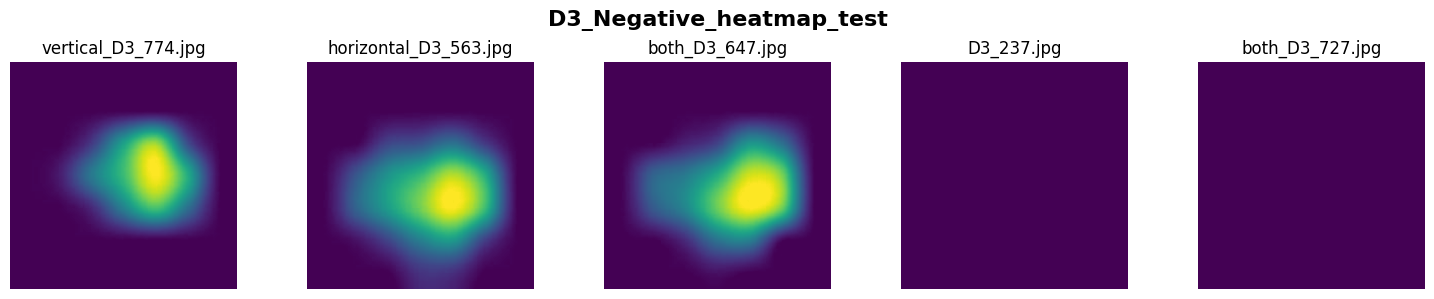

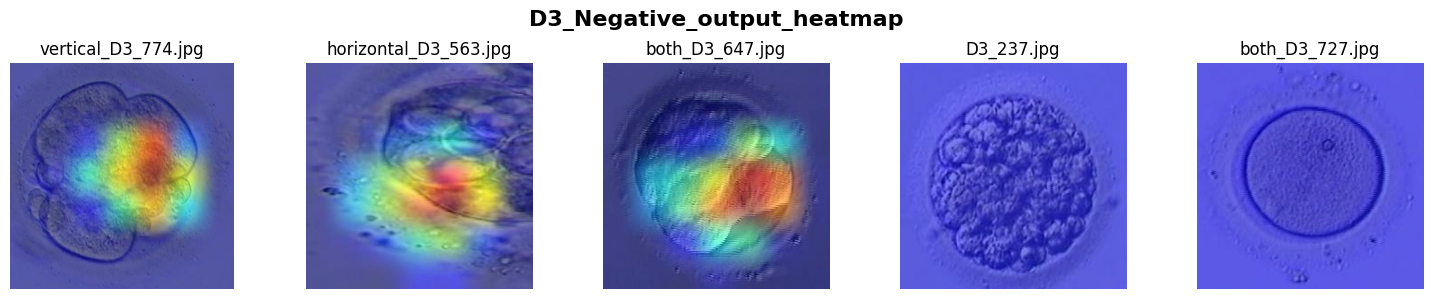

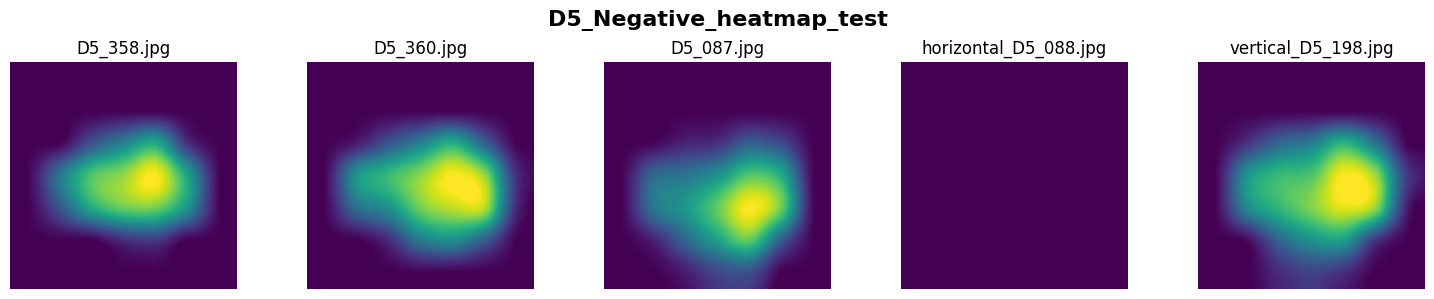

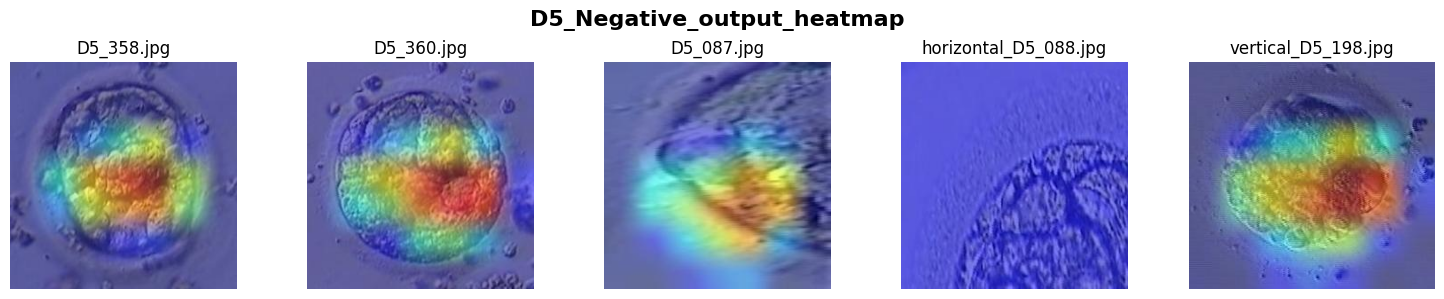

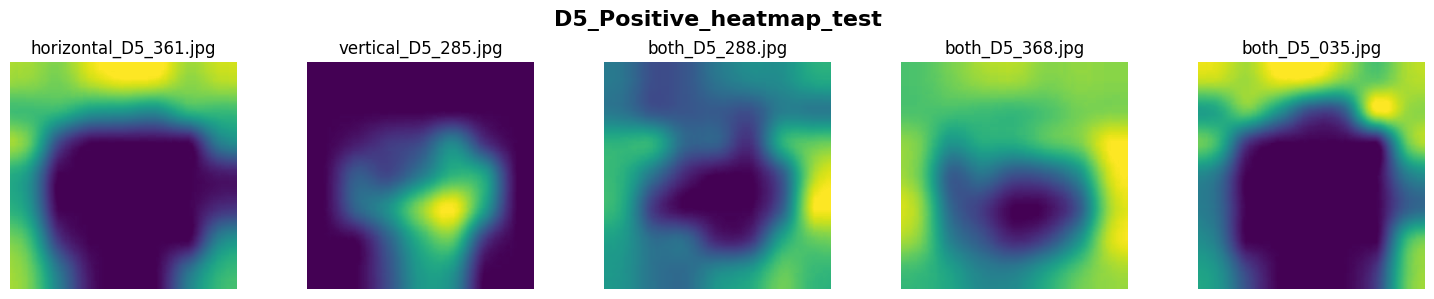

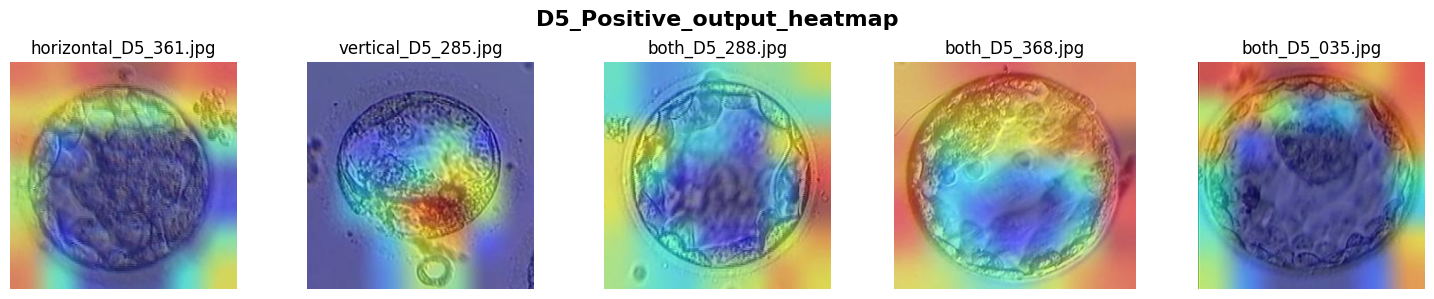

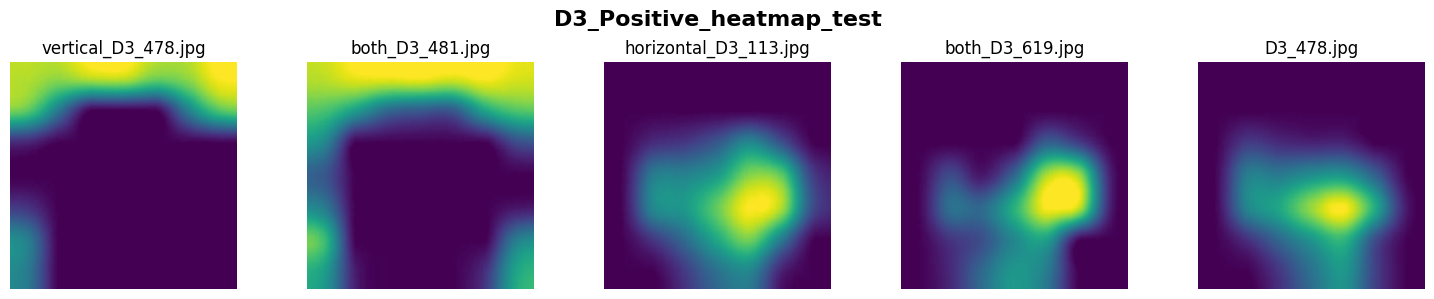

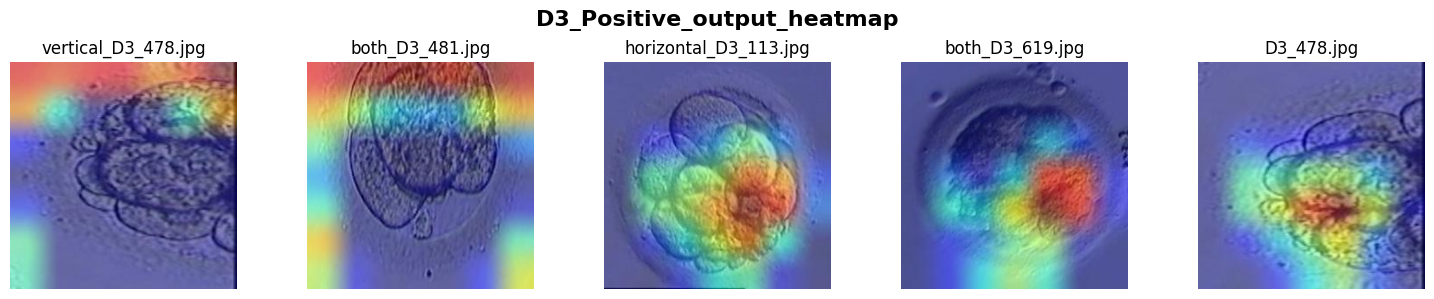

In [9]:
last_conv_layer_name = 'conv5_block3_3_conv'
model_version_gradcam = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/Grad-Cam_train_result1/ResNet50_46/All_data"
visualization(model_version_gradcam = model_version_gradcam, layerName = last_conv_layer_name)

['D3_Negative_heatmap_test', 'D3_Negative_output_heatmap', 'D5_Negative_heatmap_test', 'D5_Negative_output_heatmap', 'D5_Positive_heatmap_test', 'D5_Positive_output_heatmap', 'D3_Positive_heatmap_test', 'D3_Positive_output_heatmap']


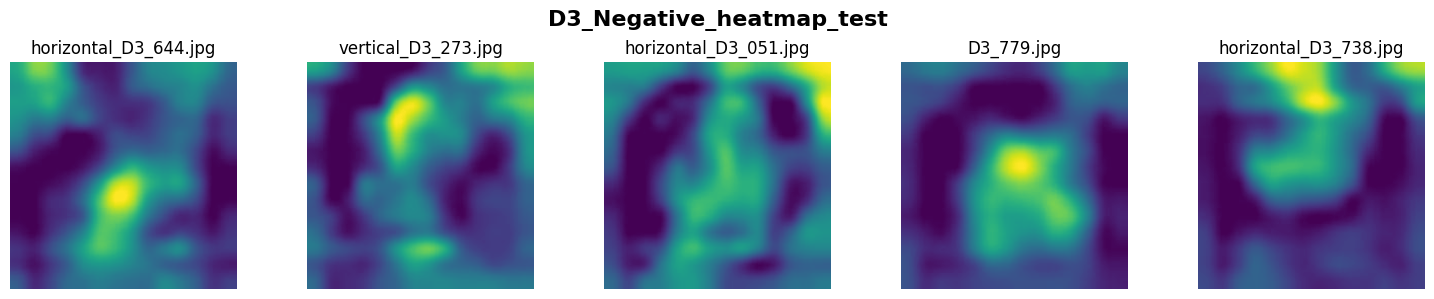

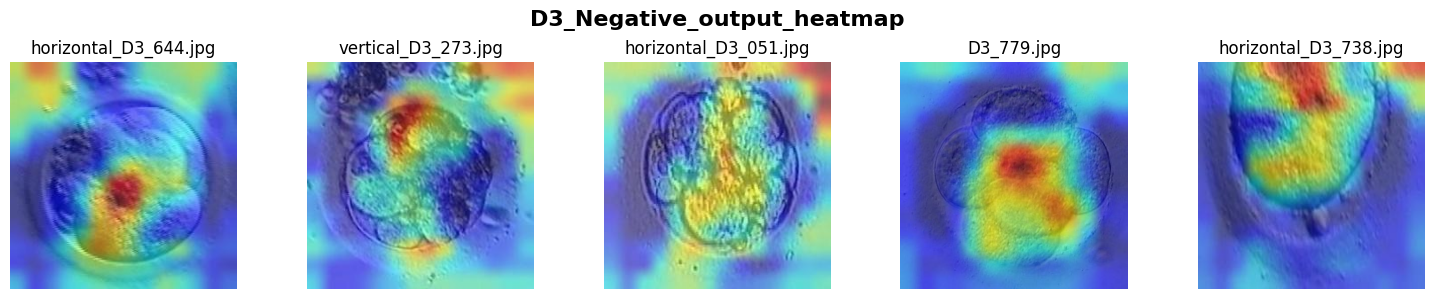

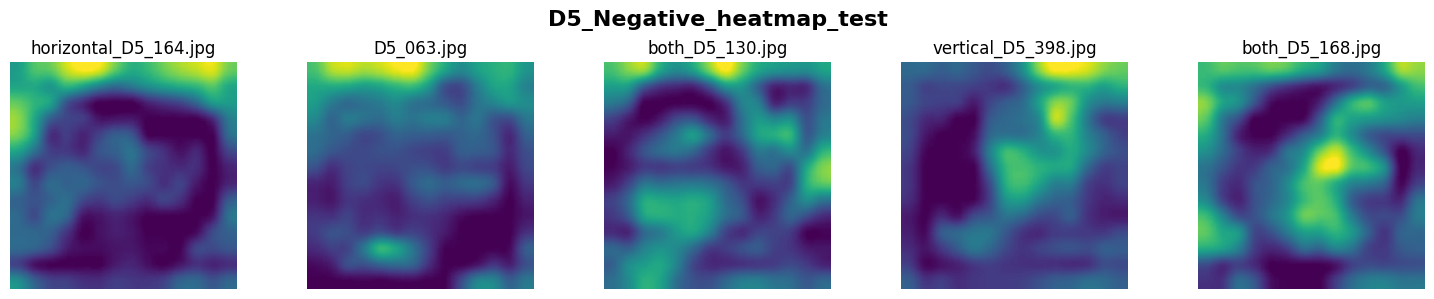

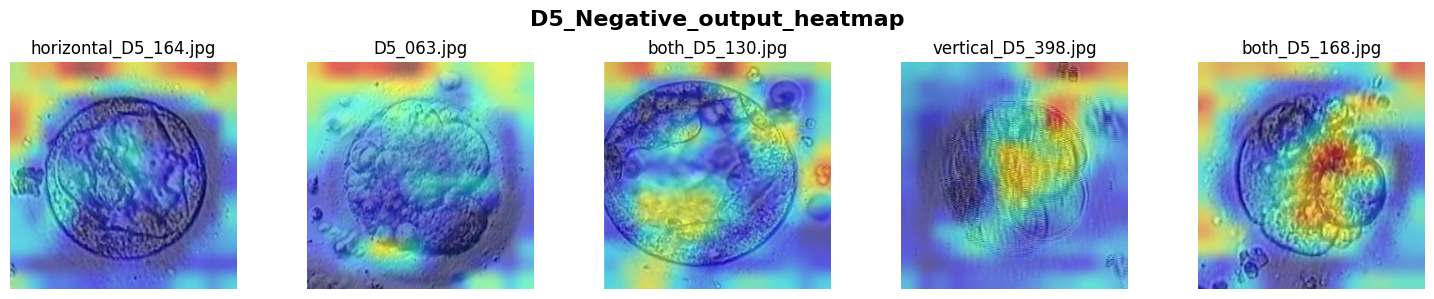

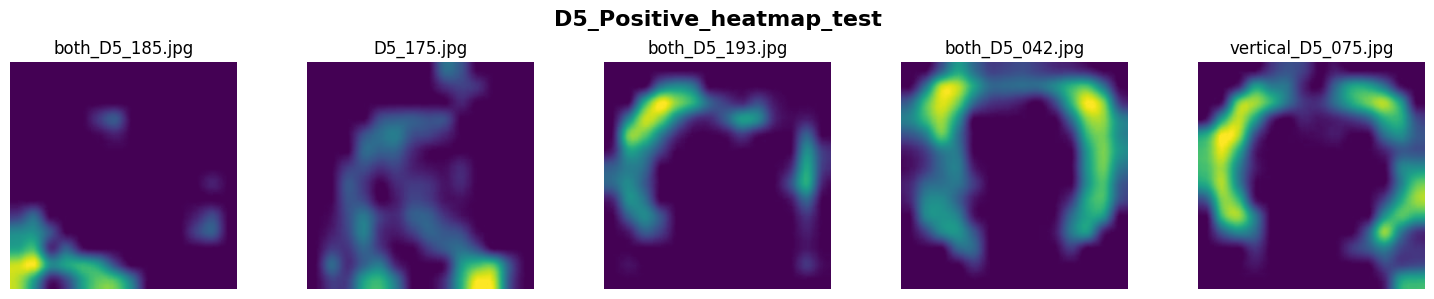

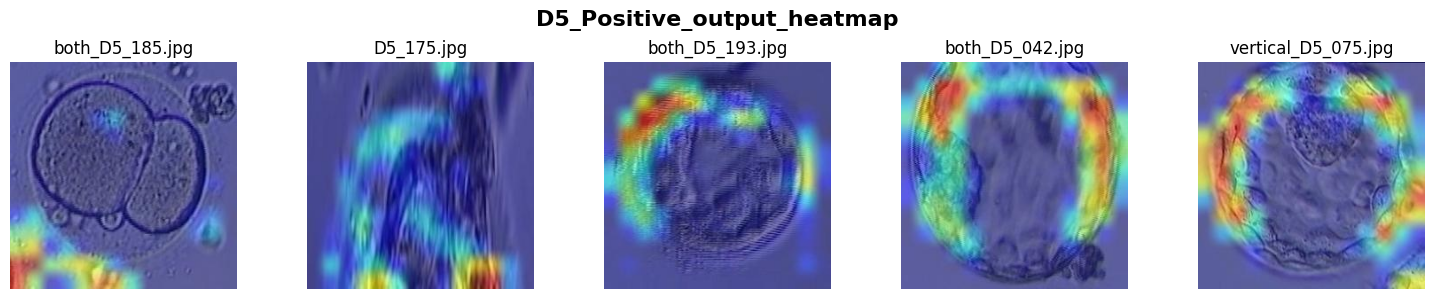

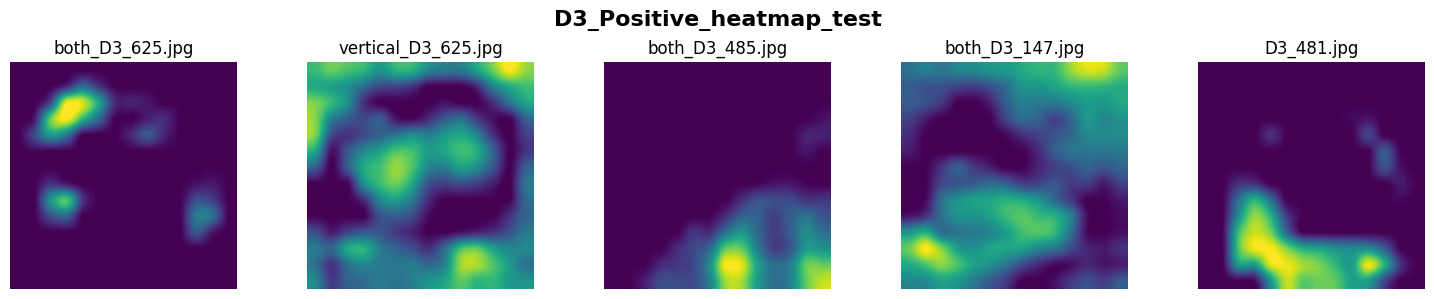

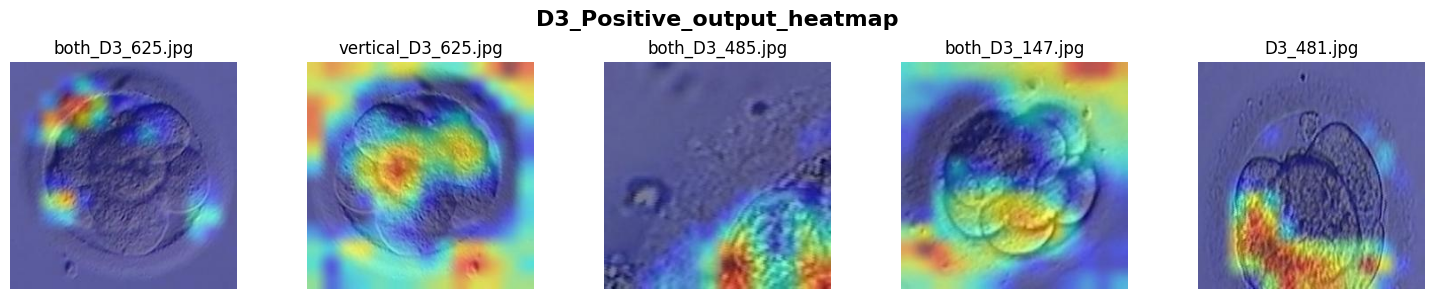

In [ ]:
model_version_gradcam = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/Grad-Cam_train_result1/VGG19_39/All_data"
visualization(model_version_gradcam = model_version_gradcam, layerName = 'block5_conv4')

# bootstrapping

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import torch
import torchvision

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.v2 as t
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from tabulate import tabulate
from sklearn.model_selection import KFold, StratifiedKFold
import gc

from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython import display
display.clear_output()
import random
import tensorflow as tf
import os
import json
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(42)

seeding done!!!


###  

In [ ]:
def preprocess_jpeg(jpeg_path):

    img = cv2.imread(jpeg_path)
#     greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))

    return img

In [ ]:
BATCH_SIZE = 32  # Adjust as needed
NUM_EPOCHS = 20
LR = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
#threshold = 0.3

cpu


In [ ]:
def predict(best_model, test_loader):
    best_model.eval()
    model_preds = []
    # id_list = []
    with torch.no_grad():
        # Test out inference with 5 samples
        for idx, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            predicts = best_model(inputs)
            preds =F.sigmoid(predicts.cpu()).numpy().flatten()
            y_pred = (preds > 0.4).astype(int)
            model_preds.extend(y_pred.tolist())

    return model_preds

###  

In [ ]:
threshold = 0.42

In [ ]:
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import warnings
warnings.filterwarnings('ignore')# Load the iris dataset

def bootstrap(normalized_testdata, model , threshold, n_samples=2000):
    models = []
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    print("label_mode", label_mode)
    for i in range(n_samples):
        if i % 10 == 0:
            print(i)

        X_val = []
        y_val = []
        y_true = []

        for images, labels in normalized_testdata:
            X_val.extend(images.numpy())
            y_val.extend(labels.numpy())

        X_val = np.array(X_val)
        y_val = np.array(y_val)

        # Resample tập dữ liệu
        X_resampled, y_resampled = resample(X_val, y_val, replace=True)

        # Lưu tập dữ liệu resampled vào biến
        normalized_resampled_testData = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled))
        normalized_resampled_testData = normalized_resampled_testData.batch(32).prefetch(tf.data.AUTOTUNE)

        if label_mode == "binary":
            threshold = threshold
            for images, labels in normalized_resampled_testData:
                y_true.extend(labels.numpy())
            y_true = np.array(y_true)
            y_true = np.squeeze(y_true)
            #print(y_true)
            y_pred = model.predict(normalized_resampled_testData)
            y_pred = np.squeeze(y_pred)

            y_pred_binary = np.empty_like(y_pred)
            for i in range(len(y_pred)):
              if y_pred[i] >= threshold:
                y_pred_binary[i] = 1
              else:
                y_pred_binary[i] = 0

        elif label_mode == "categorical":
            threshold = "None"
            for images, labels in normalized_resampled_testData:
              y_true.extend(labels.numpy())
            y_true = np.array(y_true)
            y_true = np.argmax(y_true, axis=1)
            # Đánh giá mô hình trên tập kiểm tra
            y_pred = model.predict(normalized_resampled_testData)
            y_pred_binary = np.argmax(y_pred, axis=1)


        # for images, labels in normalized_resampled_valData:
        #     y_true.extend(labels.numpy())


        # y_true = np.array(y_true)
        # y_true = np.argmax(y_true, axis=1)
        # # Đánh giá mô hình trên tập kiểm tra
        # y_pred = model.predict(normalized_resampled_valData)
        # y_pred_binary = np.argmax(y_pred, axis=1)

        # Tính toán các metrics như precision, recall, f1 score
        precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred_binary, average='weighted')
        accuracy = accuracy_score(y_true, y_pred_binary)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
#         results = {'accuracy': accuracy, 'f1score': f1score, 'precision': precision, 'recall': recall}
#         print(results)
#         break

    return accuracys, precisions, recalls, f1_scores




## Bootstrapping for model ResNet50

In [ ]:
accuracys, precisions, recalls, f1_scores =   bootstrap(normalized_testdata = normalized_testData, model = model_20_epoch_best_ResNet50, threshold = threshold, n_samples=2000)
bootstaping_file = f'/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_ResNet50_grad_cam_part46_original_normalize-1_1/All/model_20_epoch/bootstrap.csv'

label_mode categorical
0
6/6 [==============================] - 0s 93ms/step
10
6/6 [==============================] - 1s 102ms/step
20
6/6 [==============================] - 1s 99ms/step
30
6/6 [==============================] - 1s 95ms/step
40
6/6 [==============================] - 0s 93ms/step
50
6/6 [==============================] - 0s 92ms/step
60
6/6 [==============================] - 0s 92ms/step
70
6/6 [==============================] - 1s 95ms/step
80
6/6 [==============================] - 0s 92ms/step
90
6/6 [==============================] - 1s 108ms/step
100
6/6 [==============================] - 1s 110ms/step
110
6/6 [==============================] - 0s 91ms/step
120
6/6 [==============================] - 1s 107ms/step
130
6/6 [==============================] - 1s 96ms/step
140
6/6 [==============================] - 0s 91ms/step
150
6/6 [==============================] - 0s 92ms/step
160
6/6 [==============================] - 0s 92ms/step
170
6/6 [=======================

In [ ]:
# Save the results to a Pandas dataframe
pred_df = pd.DataFrame(
    {
        "Accuracy": accuracys,
        "Precision": precisions,
        "Recall": recalls,
        "F1": f1_scores,
    }
)
pred_df.to_csv(bootstaping_file)

In [ ]:
accuracys, precisions, recalls, f1_scores =   bootstrap(normalized_testdata = normalized_testData, model = model_20_epoch_best_VGG, threshold = threshold, n_samples=2000)
bootstaping_file = f'/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_VGG19_grad_cam_part39_transform_learning_normalize-1_1/All/model_20_epoch/bootstrap.csv'

In [ ]:
# Save the results to a Pandas dataframe
pred_df = pd.DataFrame(
    {
        "Accuracy": accuracys,
        "Precision": precisions,
        "Recall": recalls,
        "F1": f1_scores,
    }
)
pred_df.to_csv(bootstaping_file)

# draw validation accuracy and loss

In [10]:
import matplotlib.pyplot as plt
import json

def draw_loss_acc(filejson, title):
    with open(filejson) as f:
        data = json.load(f)

    # Get the value arrays from the data
    loss = data['loss'][:20]
    val_loss = data['val_loss'][:20]
    accuracy = data['accuracy'][:20]
    val_accuracy = data['val_accuracy'][:20]

    # Create the plot
    epochs = range(0, len(loss))

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.05)

    # Plot 1: Loss and Val_loss
    axs[0].plot([x + 1 for x in epochs], loss, 'b', label='Training loss')
    axs[0].plot([x + 1 for x in epochs], val_loss, 'r', label='Validation loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot 2: Accuracy and Val_accuracy
    axs[1].plot([x + 1 for x in epochs], accuracy, 'b', label='Training accuracy')
    axs[1].plot([x + 1 for x in epochs], val_accuracy, 'r', label='Validation accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Set the x-axis range from 0 to 20
    axs[0].set_xlim([0, 20])
    axs[1].set_xlim([0, 20])

    # Set integer ticks on the x-axis
    axs[0].xaxis.set_major_locator(plt.FixedLocator(range(1, 21)))
    axs[1].xaxis.set_major_locator(plt.FixedLocator(range(1, 21)))

    # Display the plot
    plt.tight_layout()
    plt.show()

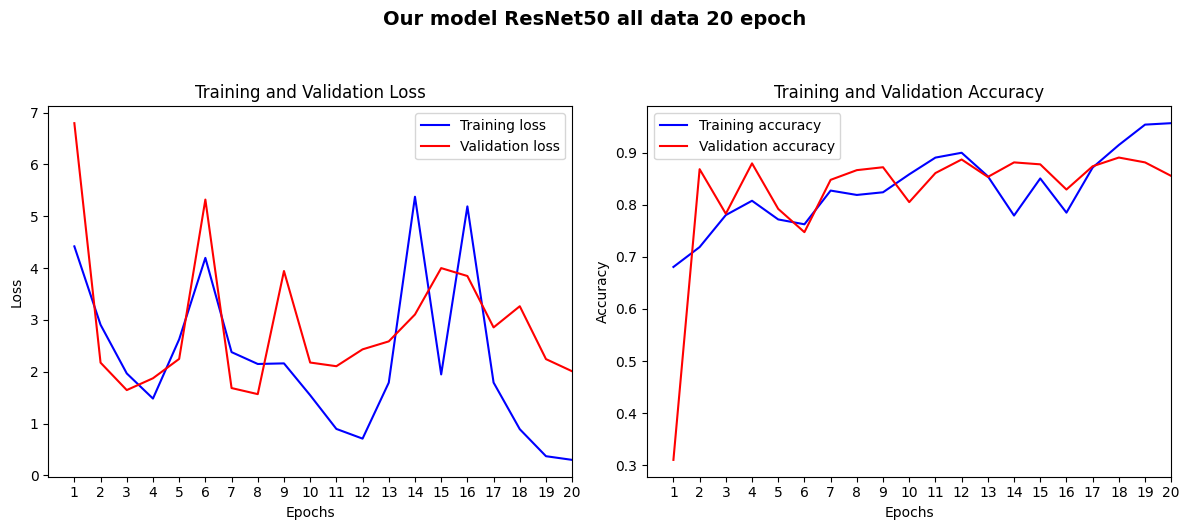

In [13]:
ResNet50_best_data = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_ResNet50_grad_cam_part46_original_normalize-1_1/All/model_20_epoch/model_20epoch_ResNet50_data_all_random_normalize_softmax_lr_1e-3_original.json"
title = 'Our model ResNet50 all data 20 epoch'
draw_loss_acc(ResNet50_best_data, title = title)

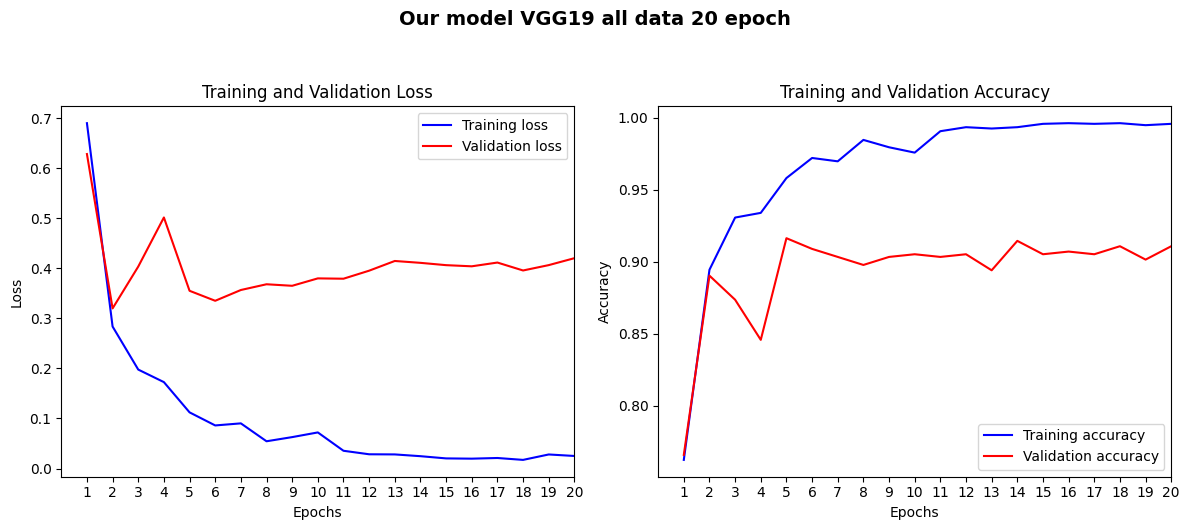

In [12]:
vgg19_best_data = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_VGG19_grad_cam_part39_original_normalize-1_1/All/model_20_epoch/model_20epoch_VGG19_data_all_random_normalize_softmax_lr_1e-3_original.json"
title = 'Our model VGG19 all data 20 epoch'
draw_loss_acc(vgg19_best_data, title = title)

In [14]:
# draw validation accuracy and loss
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file JSON
import json
def draw_loss_acc_HA(filejson, title):

    with open(filejson) as f:
        data = json.load(f)


    # Lấy các mảng giá trị từ dữ liệu
    loss = data['train_loss']
    val_loss = data['valid_loss']
    accuracy = data['train_acc']
    val_accuracy = data['valid_acc']

    # Tạo đồ thị
    epochs = range(1, len(loss) + 1)

    # Tạo khung đồ thị
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.05)
    # Đồ thị 1: Loss và Val_loss
    axs[0].plot(epochs, loss, 'b', label='Training loss')
    axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Đồ thị 2: Accuracy và Val_accuracy
    axs[1].plot(epochs, accuracy, 'b', label='Training accuracy')
    axs[1].plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    axs[0].set_xlim([0, 20])
    axs[1].set_xlim([0, 20])

    # Set integer ticks on the x-axis
    axs[0].xaxis.set_major_locator(plt.FixedLocator(range(1, 21)))
    axs[1].xaxis.set_major_locator(plt.FixedLocator(range(1, 21)))

    # Hiển thị đồ thị
    plt.tight_layout()
    plt.show()

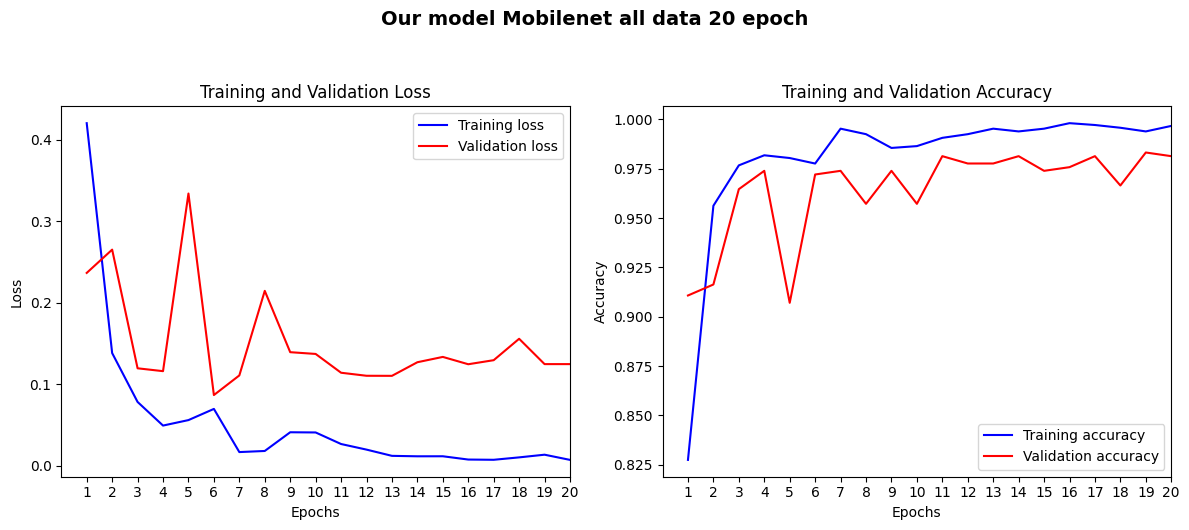

In [15]:
mobilenet_best_data = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/Mobilenet_our/All_train.json"
title = 'Our model Mobilenet all data 20 epoch'
draw_loss_acc_HA(mobilenet_best_data, title = title)

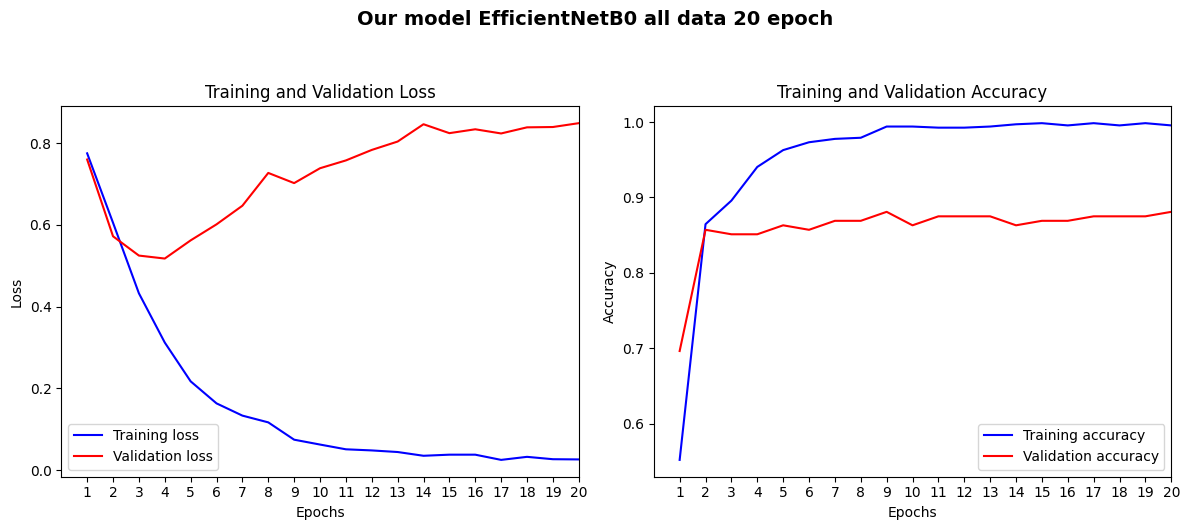

In [16]:
effi_best_data = "/content/drive/MyDrive/cuoc_thi_wcs2023_p2/efficientnetB0_our/All_train.json"
title = 'Our model EfficientNetB0 all data 20 epoch'
draw_loss_acc_HA(effi_best_data, title = title)

# draw distribution bootstrapping

In [17]:
MobileNet = pd.read_csv('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/Mobilenet_our/boostraping.csv')
EfficientNet = pd.read_csv('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/efficientnetB0_our/boostraping.csv')
VGG19 = pd.read_csv('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_VGG19_grad_cam_part39_original_normalize-1_1/All/model_20_epoch/bootstrap.csv')
ResNet50 = pd.read_csv('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_ResNet50_grad_cam_part46_original_normalize-1_1/All/model_20_epoch/bootstrap.csv')


<ipython-input-18-9d303331341b>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(MobileNet['Accuracy'], hist=False, color="black", ax=axes[0], label=keys[0])
<ipython-input-18-9d303331341b>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(EfficientNet['Accuracy'], hist=False,

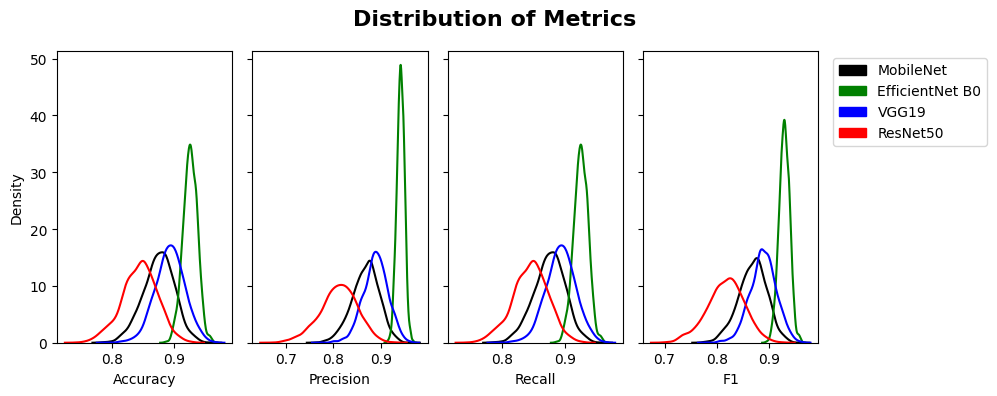

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

keys = ['MobileNet', 'EfficientNet B0', 'VGG19', 'ResNet50']
colors = ['black', 'green', 'blue', 'red']

fig, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=True, dpi=100)
main_title = "Distribution of Metrics"
fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.98)

sns.distplot(MobileNet['Accuracy'], hist=False, color="black", ax=axes[0], label=keys[0])
sns.distplot(EfficientNet['Accuracy'], hist=False, color="green", ax=axes[0], label=keys[1])
sns.distplot(VGG19['Accuracy'], hist=False, color="blue", ax=axes[0], label=keys[2])
#sns.distplot(VGG19_best['Accuracy'], hist=False, color="red", ax=axes[0], label=keys[3])
sns.distplot(ResNet50['Accuracy'], hist=False, color="red", ax=axes[0], label=keys[3])

sns.distplot(MobileNet['Precision'], hist=False, color="black", ax=axes[1])
sns.distplot(EfficientNet['Precision'], hist=False, color="green", ax=axes[1])
sns.distplot(VGG19['Precision'], hist=False, color="blue", ax=axes[1])
#sns.distplot(VGG19_best['Precision'], hist=False, color="red", ax=axes[1])
sns.distplot(ResNet50['Precision'], hist=False, color="red", ax=axes[1])

sns.distplot(MobileNet['Recall'], hist=False, color="black", ax=axes[2])
sns.distplot(EfficientNet['Recall'], hist=False, color="green", ax=axes[2])
sns.distplot(VGG19['Recall'], hist=False, color="blue", ax=axes[2])
#sns.distplot(VGG19_best['Recall'], hist=False, color="red", ax=axes[2])
sns.distplot(ResNet50['Recall'], hist=False, color="red", ax=axes[2])

sns.distplot(MobileNet['F1'], hist=False, color="black", ax=axes[3])
sns.distplot(EfficientNet['F1'], hist=False, color="green", ax=axes[3])
sns.distplot(VGG19['F1'], hist=False, color="blue", ax=axes[3])
#sns.distplot(VGG19_best['F1'], hist=False, color="red", ax=axes[3])
sns.distplot(ResNet50['F1'], hist=False, color="red", ax=axes[3])

# Tạo bảng ghi chú
legend_elements = [mpatches.Patch(color=colors[i], label=keys[i]) for i in range(len(keys))]
axes[3].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2, 1))

# Hiển thị đồ thị
plt.tight_layout()
plt.show()

#Compare with all model

In [21]:
def load_result(file):
    with open(file,'r') as f:
        results = json.load(f)
        return results

In [22]:
mobileNet_result_all =load_result('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/Mobilenet_our/All.json')
print(mobileNet_result_all)

{'accuracy': 0.875, 'f1score': 0.8691294387170677, 'precision': 0.8657094594594594, 'recall': 0.875}


In [23]:
EfficientNet_result_all =load_result('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/efficientnetB0_our/All.json')
print(EfficientNet_result_all)

{'accuracy': 0.8809523809523809, 'f1score': 0.8845172426732708, 'precision': 0.8894342653955654, 'recall': 0.8809523809523809}


In [24]:
VGG19_all =load_result('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_VGG19_grad_cam_part39_original_normalize-1_1/All/model_20_epoch/result_best_model_20_epoch_None1.json')
print(VGG19_all)

{'accuracy': 0.7738095238095238, 'precision': 0.7579365079365079, 'recall': 0.7738095238095238, 'f1score': 0.765535089598058}


In [25]:
ResNet50_result_all =load_result('/content/drive/MyDrive/cuoc_thi_wcs2023_p2/weight_ResNet50_grad_cam_part46_original_normalize-1_1/All/model_20_epoch/result_best_model_20_epoch_None.json')
print(ResNet50_result_all)

{'accuracy': 0.7976190476190477, 'precision': 0.7346003253646566, 'recall': 0.7976190476190477, 'f1score': 0.7629894179894181}


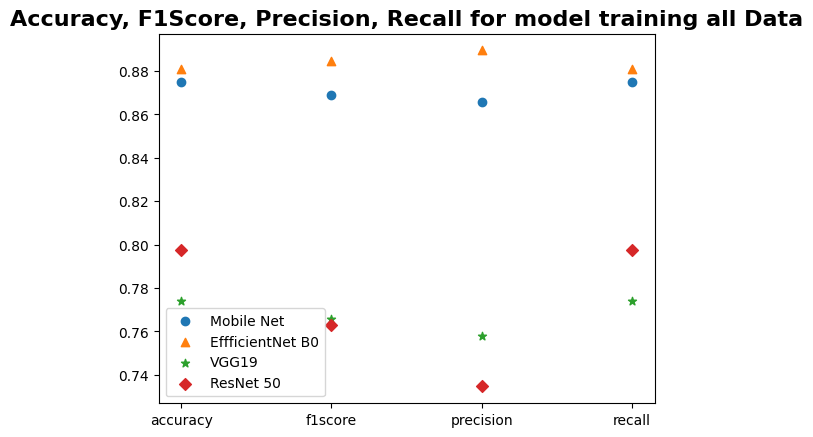

In [26]:
main_title = "Accuracy, F1Score, Precision, Recall for model training all Data"
plt.title(main_title, fontsize=16, fontweight='bold')

plt.scatter(mobileNet_result_all.keys(), mobileNet_result_all.values(), marker='o', label='Mobile Net')
plt.scatter(EfficientNet_result_all.keys(), EfficientNet_result_all.values(), marker='^', label='EffficientNet B0')
plt.scatter(VGG19_all.keys(), VGG19_all.values(), marker='*', label='VGG19')
plt.scatter(ResNet50_result_all.keys(), ResNet50_result_all.values(), marker='D', label='ResNet 50')
plt.legend()